In [1]:
%pip install alpaca-trade-api   #changed ! to %
%pip install alpaca-py
%pip install pandas_market_calendars   
%pip install twelvedata 

Note: you may need to restart the kernel to use updated packages.


ERROR: Invalid requirement: '#changed': Expected package name at the start of dependency specifier
    #changed
    ^


   ---------------------------------------- 0.0/1.9 MB ? eta -:--:--
   ---------------------------------------- 1.9/1.9 MB 15.2 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import pandas_market_calendars as mcal
from datetime import datetime
import time
import csv

from alpaca.data import StockHistoricalDataClient, TimeFrame
from alpaca.data.requests import StockBarsRequest


In [17]:
'''Connecting to Alpaca API here'''

path = "../API_Keys/Alpaca_Keys.csv"

with open(path, mode='r', newline='') as file:
    csv_reader = csv.reader(file)
    API_KEY = next(csv_reader)[0]
    ALPACA_API_SECRET_KEY = next(csv_reader)[0]
    #TWELVE_DATA_KEY = next(csv_reader)[0]
    

data_client = StockHistoricalDataClient(API_KEY, ALPACA_API_SECRET_KEY)


In [18]:
'''Functions'''

def trading_days(end_d, days_back):
    nyse = mcal.get_calendar('NYSE')
    schedule = nyse.schedule(start_date=end_d - pd.Timedelta(days=days_back), end_date=end_d)
    td = schedule.index[0 : days_back] 
    return td



def call(start_date, stock, trading_days, percent_change):
    request_params = StockBarsRequest(
        symbol_or_symbols=[stock],            
        timeframe=TimeFrame.Day,
        start=start_date
    )

    # Fetch the bars data
    bars_data = data_client.get_stock_bars(request_params)
    bars_df = bars_data.df
    
    # Reset the index to separate the columns
    bars_df = bars_df.reset_index()

    # Convert the timezone of the timestamp column
    bars_df['timestamp'] = bars_df['timestamp'].dt.tz_convert('America/New_York')

    # Set the index back to symbol and timestamp if needed
    bars_df = bars_df.set_index(['symbol', 'timestamp'])

    #percent_change = [[0, 0] for i in range(len(trading_days))]
    for i in range(len(trading_days)):
        specific_date = pd.to_datetime(trading_days[i]).tz_localize('America/New_York')
        #print(specific_date)
        open_price = bars_df.loc[(stock, specific_date), 'open']
        close_price = bars_df.loc[(stock, specific_date), 'close']
        #percent_change[i][0] = f"{specific_date.date()} "
        #percent_change[i][1] = ((close_price/open_price)-1)*100
        percent_change.insert(0, [f"{specific_date.date()} ", ((close_price/open_price)-1)*100])
    return percent_change



def store_data(stock, percent_change):
    file_path = "Stocks/"+str(stock)+".csv"
    with open(file_path, mode='w', newline='') as file:   # w for a overwrite? 
        writer = csv.writer(file)
        writer.writerows(percent_change)
        
def add_ending(stock):
    file_path = "Stocks/"+str(stock)+".csv"
    with open(file_path, mode='a', newline='') as file:   # w for a overwrite? 
        writer = csv.writer(file)
        var = "end"
        writer.writerow(["--","--"])
        
        
def create_data(stock, days_back):
    #break up days back into unders 150s calls
    today = pd.Timestamp.today(tz='America/New_York').normalize()
    percent_change = []
    
    count = days_back
    
    while(True):
        if count >= 200:
            td= trading_days(today - pd.Timedelta(days=count-200), 200) # start and end dates
            start_date = today - pd.Timedelta(days=count)
            call(start_date, stock, td, percent_change)
            count -= 200
            #print(f"1' delay at {count}")
           # time.sleep(60)
        else: 
            td= trading_days(today, count)
            start_date = today - pd.Timedelta(days=count)
            call(start_date, stock, td, percent_change)
            break
    store_data(stock, percent_change)
    add_ending(stock)



In [43]:
''' Setting the days back '''

"""Bug to fix the days are required to be certain numbers and not others find out why and fix trading days only? """

create_data("SPY", 1113)  
print("spy done")
create_data("UBER", 1113) 
print("both good")

spy done
both good


In [47]:
import csv

data = []

# Read the CSV file
with open("Stocks/SPY.csv", 'r') as file:
    reader = csv.reader(file)
    for row in reader:
        # Append each row to the data list
        date = row[0].strip()
        try:                                    # this is only here becuase of the closing --,-- causing errors
            value = float(row[1].strip())
            data.append([date, value])
        except:
            pass
        data.append([date, value])

# Now data is a 2D array ready for graphing
print(data)


[['2024-10-11', 0.6127940282961708], ['2024-10-11', 0.6127940282961708], ['2024-10-10', 0.06252496656651285], ['2024-10-10', 0.06252496656651285], ['2024-10-09', 0.6943959801800625], ['2024-10-09', 0.6943959801800625], ['2024-10-08', 0.4821009081028116], ['2024-10-08', 0.4821009081028116], ['2024-10-07', -0.6126378435147961], ['2024-10-07', -0.6126378435147961], ['2024-10-04', 0.11007250808072744], ['2024-10-04', 0.11007250808072744], ['2024-10-03', 0.08107727016357646], ['2024-10-03', 0.08107727016357646], ['2024-10-02', 0.20256821264377223], ['2024-10-02', 0.20256821264377223], ['2024-10-01', -0.8336239972096204], ['2024-10-01', -0.8336239972096204], ['2024-09-30', 0.5855334665684886], ['2024-09-30', 0.5855334665684886], ['2024-09-27', -0.33485062522889963], ['2024-09-27', -0.33485062522889963], ['2024-09-26', -0.36212960061283717], ['2024-09-26', -0.36212960061283717], ['2024-09-25', -0.19259726161712232], ['2024-09-25', -0.19259726161712232], ['2024-09-24', 0.1437386060860968], ['2

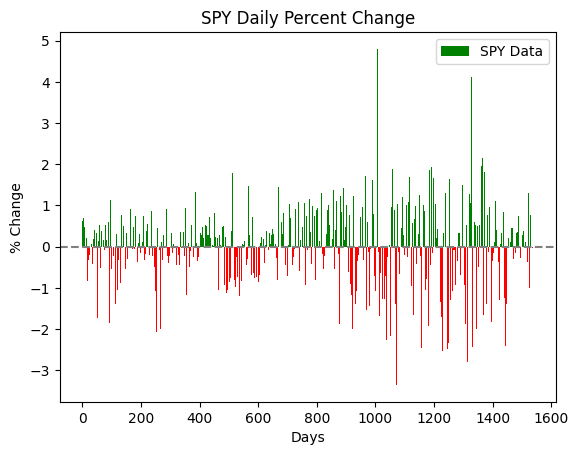

In [48]:
import matplotlib.pyplot as plt

def graph(stock, percent_change):
    days = len(percent_change)
    x = range(days)

    y = [percent[1] for percent in percent_change]

    # Determine colors for positive and negative changes
    colors = ['green' if value > 0 else 'red' for value in y]

    # Create a bar plot with the specified colors
    plt.bar(x, y, color=colors, label=stock + " Data")

    # Add title and labels
    plt.title(f'{stock} Daily Percent Change')
    plt.xlabel('Days')
    plt.ylabel('% Change')

    # Add a legend
    plt.legend()
    plt.axhline(y=0, color='gray', linestyle='--')

    # Display the plot
    plt.show()

# Example data
graph("SPY", data)

In [49]:
def calculate_transition_probabilities(data):
    # Initialize counters
    pos_to_pos = 0
    pos_to_neg = 0
    neg_to_pos = 0
    neg_to_neg = 0
    
    # Iterate through the data to count transitions
    for i in range(len(data) - 1):
        current_day = data[i][1]
        next_day = data[i + 1][1]
        
        if current_day > 0 and next_day > 0:
            pos_to_pos += 1
        elif current_day > 0 and next_day <= 0:
            pos_to_neg += 1
        elif current_day <= 0 and next_day > 0:
            neg_to_pos += 1
        elif current_day <= 0 and next_day <= 0:
            neg_to_neg += 1
    
    # Calculate total transitions from positive and negative days
    total_pos = pos_to_pos + pos_to_neg
    total_neg = neg_to_pos + neg_to_neg
    
    # Calculate probabilities
    prob_pos_to_pos = pos_to_pos / total_pos if total_pos > 0 else 0
    prob_pos_to_neg = pos_to_neg / total_pos if total_pos > 0 else 0
    prob_neg_to_pos = neg_to_pos / total_neg if total_neg > 0 else 0
    prob_neg_to_neg = neg_to_neg / total_neg if total_neg > 0 else 0
    
    # Construct the transition probability matrix
    transition_matrix = [
        [prob_pos_to_pos, prob_pos_to_neg],  # From positive day
        [prob_neg_to_pos, prob_neg_to_neg]   # From negative day
    ]
    
    return transition_matrix

# Example data
graph = calculate_transition_probabilities(data)

print(f"p-p: {graph[0][0]},   p-n: {graph[0][1]},    n-p: {graph[1][0]},  n-n: {graph[1][1]}")


p-p: 0.7726190476190476,   p-n: 0.22738095238095238,    n-p: 0.2722063037249284,  n-n: 0.7277936962750716


In [11]:
from twelvedata import TDClient

# Initialize client - apikey parameter is requiered
td = TDClient(apikey=TWELVE_DATA_KEY)

# Construct the necessary time series
ts = td.time_series(
    symbol="AAPL",
    interval="1day",
    outputsize=1,
    timezone="America/New_York",
)
  
# Returns pandas.DataFrame
ts.as_pandas()

,open,high,low,close,volume
datetime,,,,,
2024-06-14,213.85001,215.17,211.3,212.49001,69175600
